In [2]:
import matplotlib.pyplot as plt
import glob
import pandas as pd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [41]:
from scipy.optimize import curve_fit

def make_binned_noise_plot(fig, ax, label, path_todir, make_fit=True):

    # Find all CSV files in the directory
    csv_files = glob.glob(path_todir + "noise_tauc_data_*.csv")

    # Read each CSV file into a pandas DataFrame and store in a list
    dfs = [pd.read_csv(file) for file in csv_files]

    # Concatenate all DataFrames into a single DataFrame
    df = pd.concat(dfs, ignore_index=True)

    # Bin the data by deltaR
    bins = np.logspace(np.log10(df['deltaR'].min()), np.log10(df['deltaR'].max()), num=20)
    df['deltaR_binned'] = pd.cut(df['deltaR'], bins, labels=False)

    # Calculate the mean tau_c for each bin
    df_binned = df.groupby('deltaR_binned')['tau_c'].mean().reset_index()
    bin_centers = (bins[:-1] + bins[1:]) / 2
    df_binned['deltaR'] = bin_centers[df_binned['deltaR_binned'].astype(int)]

    # Plot the binned data
    ax.scatter(df_binned['deltaR'], df_binned['tau_c'], label=label)
    # Calculate the standard deviation of tau_c for each bin
    df_std = df.groupby('deltaR_binned')['tau_c'].std().reset_index()
    df_binned['tau_c_std'] = df_std['tau_c']

    # Define the fitting function (power law)
    def power_law(x, a, b):
        return a * np.power(x, b)

    # Perform the curve fit
    popt, pcov = curve_fit(power_law, df_binned['deltaR'], df_binned['tau_c'], p0=[1, -1])

    # Generate x values for the fitted line
    x_fit = np.logspace(np.log10(df_binned['deltaR'].min()), np.log10(df_binned['deltaR'].max()), num=50)

    # Calculate the y values for the fitted line
    y_fit = power_law(x_fit, *popt)

    # Plot the fitted line
    if make_fit:
        ax.plot(x_fit, y_fit, color='red', linestyle='--', label=f'Fit: a={popt[0]:.2f}, b={popt[1]:.2f}')
        # Filter the data for deltaR < 10^(-2)
        df_filtered = df_binned[df_binned['deltaR'] < 10**(-2.5)]

        # Perform the curve fit on the filtered data
        if not df_filtered.empty:
            popt_filtered, pcov_filtered = curve_fit(power_law, df_filtered['deltaR'], df_filtered['tau_c'], p0=[1, -1])

            # Generate x values for the fitted line
            x_fit_filtered = np.logspace(np.log10(df_filtered['deltaR'].min()), np.log10(df_filtered['deltaR'].max()), num=50)

            # Calculate the y values for the fitted line
            y_fit_filtered = power_law(x_fit_filtered, *popt_filtered)

            # Plot the fitted line
            ax.plot(x_fit_filtered, y_fit_filtered, color='green', linestyle='--', label=f'Fit: a={popt_filtered[0]:.2f}, b={popt_filtered[1]:.2f}')
            
    # Add error bars to the scatter plot
    ax.errorbar(df_binned['deltaR'], df_binned['tau_c'], yerr=df_binned['tau_c_std'], fmt='none', ecolor='gray', capsize=3)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('deltaR')
    ax.set_ylabel('tau_c')
    ax.grid(True)
    ax.legend()

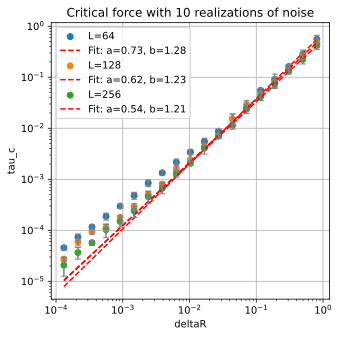

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
make_binned_noise_plot(fig, ax, "L=64","../results/9-9-depinning-FIRE/l-64/simulation_backups/")
make_binned_noise_plot(fig, ax, "L=128", "../results/9-9-depinning-FIRE/l-128/simulation_backups/")
make_binned_noise_plot(fig,ax,"L=256", "../results/9-9-depinning-FIRE/l-256/simulation_backups/")
plt.title("Critical force with 10 realizations of noise")
plt.show()

Text(0.5, 1.0, 'Critical froce with a system size L=8 (10 realizations)')

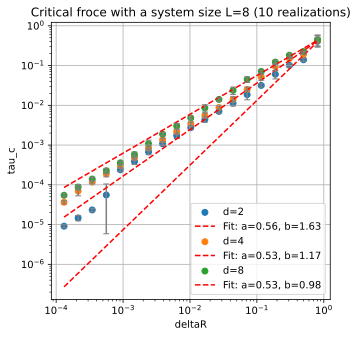

In [13]:
fig, ax = plt.subplots(figsize=(5,5))
make_binned_noise_plot(fig, ax, "d=2", "../results/15-9-depinning/partial/l-8-d-2/force_data/")
make_binned_noise_plot(fig, ax, "d=4", "../results/15-9-depinning/partial/l-8-d-4/force_data/")
make_binned_noise_plot(fig, ax, "d=8", "../results/15-9-depinning/partial/l-8-d-8/force_data/")
ax.set_title("Critical froce with a system size L=8 (10 realizations)")

Text(0.5, 1.0, 'Critical force with L=128 (10 realizations)')

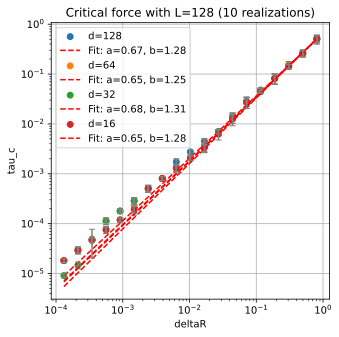

In [19]:
fig, ax = plt.subplots(figsize=(5,5))

make_binned_noise_plot(fig, ax, "d=128", "../results/15-9-depinning/partial/l-128-d-128/force_data/")
make_binned_noise_plot(fig, ax, "d=64", "../results/15-9-depinning/partial/l-128-d-64/force_data/")
make_binned_noise_plot(fig, ax, "d=32", "../results/15-9-depinning/partial/l-128-d-32/force_data/")
make_binned_noise_plot(fig, ax, "d=16", "../results/15-9-depinning/partial/l-128-d-16/force_data/")

ax.set_title("Critical force with L=128 (10 realizations)")


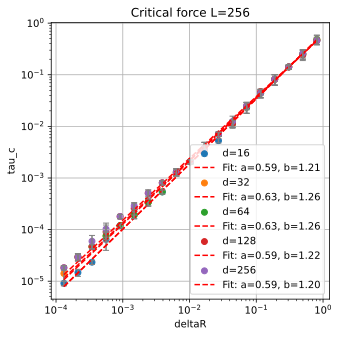

In [15]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_title("Critical force L=256")
make_binned_noise_plot(fig, ax, "d=16", "../results/15-9-depinning/partial/l-256-d-16/force_data/")
make_binned_noise_plot(fig, ax, "d=32", "../results/15-9-depinning/partial/l-256-d-32/force_data/")
make_binned_noise_plot(fig, ax, "d=64", "../results/15-9-depinning/partial/l-256-d-64/force_data/")
make_binned_noise_plot(fig, ax, "d=128", "../results/15-9-depinning/partial/l-256-d-128/force_data/")
make_binned_noise_plot(fig, ax, "d=256", "../results/15-9-depinning/partial/l-256-d-256/force_data/")

Text(0.5, 1.0, 'L=512')

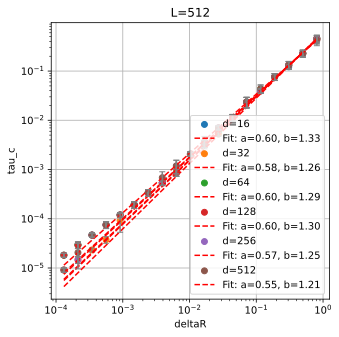

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
make_binned_noise_plot(fig, ax, "d=16", "../results/15-9-depinning/partial/l-512-d-16/force_data/")
make_binned_noise_plot(fig, ax, "d=32", "../results/15-9-depinning/partial/l-512-d-32/force_data/")
make_binned_noise_plot(fig, ax, "d=64", "../results/15-9-depinning/partial/l-512-d-64/force_data/")
make_binned_noise_plot(fig, ax, "d=128", "../results/15-9-depinning/partial/l-512-d-128/force_data/")
make_binned_noise_plot(fig, ax, "d=256", "../results/15-9-depinning/partial/l-512-d-256/force_data/")
make_binned_noise_plot(fig, ax, "d=512", "../results/15-9-depinning/partial/l-512-d-512/force_data/")
ax.set_title("L=512")

Text(0.5, 1.0, 'L=1024')

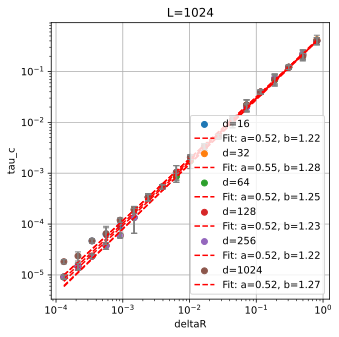

In [21]:
fig, ax = plt.subplots(figsize=(5,5))
make_binned_noise_plot(fig, ax, "d=16", "../results/15-9-depinning/partial/l-1024-d-16/force_data/")
make_binned_noise_plot(fig, ax, "d=32", "../results/15-9-depinning/partial/l-1024-d-32/force_data/")
make_binned_noise_plot(fig, ax, "d=64", "../results/15-9-depinning/partial/l-1024-d-64/force_data/")
make_binned_noise_plot(fig, ax, "d=128", "../results/15-9-depinning/partial/l-1024-d-128/force_data/")
make_binned_noise_plot(fig, ax, "d=256", "../results/15-9-depinning/partial/l-1024-d-256/force_data/")
make_binned_noise_plot(fig, ax, "d=1024", "../results/15-9-depinning/partial/l-1024-d-1024/force_data/")
ax.set_title("L=1024")

Text(0.5, 1.0, 'Different system sizes')

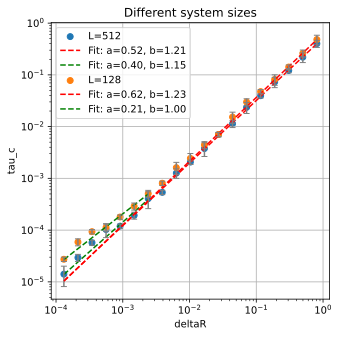

In [45]:
fig, ax = plt.subplots(figsize=(5,5))
make_binned_noise_plot(fig, ax, "L=512", "../results/15-9-depinning/perfect/l-512/force_data/", make_fit=True)
# make_binned_noise_plot(fig, ax, "L=256", "../results/15-9-depinning/perfect/l-256/force_data/", make_fit=False)
make_binned_noise_plot(fig, ax, "L=128", "../results/15-9-depinning/perfect/l-128/force_data/", make_fit=True)
# make_binned_noise_plot(fig, ax, "L=64", "../results/15-9-depinning/perfect/l-64/force_data/", make_fit=False)
# make_binned_noise_plot(fig, ax, "L=32", "../results/15-9-depinning/perfect/l-32/force_data/", make_fit=False)
# make_binned_noise_plot(fig, ax, "L=16", "../results/15-9-depinning/perfect/l-16/force_data/", make_fit=False)
# make_binned_noise_plot(fig, ax, "L=8", "../results/15-9-depinning/perfect/l-8/force_data/", make_fit=False)
ax.set_title("Different system sizes")
